In [ ]:
import sys
sys.path.append('../../scripts')
from utils import *

In [7]:
input_df_path = 'results/training/training_input.csv'
refs_path = 'data/reference_database.xlsx'
contig_fasta_path = 'results/training/sampling/2025-06-11_sampled_contigs_60.fasta'

In [8]:
# load data
input_df = pd.read_csv(input_df_path, index_col=0)
refs = pd.read_excel(refs_path)
contigs = SeqIO.to_dict(SeqIO.parse(contig_fasta_path, "fasta"))

In [10]:
# empty list to store final predictions
fold_final_predictions = []

# iterate 30 times
for i in range(30):
    print(f"Starting iteration {i}")
    random_seed = 42 + i

    # Create 5 FOLDS of TRAIN(80%) and TEST(20%)
    folds = stratified_kfold_split(refs, n_splits=5, random_state=random_seed)

    print("Starting 5-fold cross-validation")
    for idx, (train_refs, test_refs) in enumerate(folds):
        # Prepare TRAIN and TEST data
        train_all, test_all = prepare_train_test(input_df, train_refs, test_refs)

        # subsample contigs
        selected_training_contigs = subsample_contigs(
            train_refs,
            contigs,
            num=60,
            output_dir=f"results/training/hist_test/sampling/{i}_{idx}_train_report",
            random_seed=random_seed,
        )
        selected_test_contigs = subsample_contigs(
            test_refs,
            contigs,
            num=60,
            output_dir=f"results/training/hist_test/sampling/{i}_{idx}_test_report",
            random_seed=random_seed,
        )

        # Filter train and test to keep only contig_name values that are in selected_training_contigs and selected_test_contigs respectively
        train = train_all[train_all["contig_name"].isin(selected_training_contigs)]
        test = test_all[test_all["contig_name"].isin(selected_test_contigs)]

        # check
        assert set(train["contig_name"]).issubset(set(selected_training_contigs))
        assert set(test["contig_name"]).issubset(set(selected_test_contigs))

        # Use only forward ORFs for training
        train = train[train["strand"] == "FORWARD"]

        ################################################ TRAIN PHASE

        # Train RandomForest model on subtrain data and make predictions for subtest data
        morf_predictions = train_rf_and_predict(train)

        # Train Logistic Regression model on LOOCV predictions - hist test
        bins = [10]
        mc_dict = train_lr_and_predict_hist_test(morf_predictions, bins)

        print("Training RandomForest model")
        # Train RandomForest model on all data
        morf, sorf, feature_names = train_rf_on_all_data(train)

        ##################################### TEST phase

        # Make orf predictions on test data
        test_orf_predictions = predict_orfs(test, morf, sorf, refs=True)

        print("Predicting contigs using logistic regression models")
        # Predict contigs using logistic regression histogram
        for mc_name_n, mc in mc_dict.items():
            mc_name = mc_name_n.split("_")[0]
            num = int(mc_name_n.split("_")[1])
            final_predictions = predict_contigs_hist_test(test_orf_predictions, mc, idx, mc_name, num, refs_=True)
            final_predictions["n"] = num
            final_predictions["treshold"] = 0.5
            final_predictions["random_seed"] = random_seed
            fold_final_predictions.append(final_predictions)
        break
    break


Starting iteration 0
Starting 5-fold cross-validation
Training RandomForest model
Predicting contigs using logistic regression models


In [11]:
# Save results
print("Saving results")
fold_final_predictions_df = pd.concat(fold_final_predictions)
fold_final_predictions_df["contig_length"] = (
    fold_final_predictions_df["contig_name"].str.extract(r"len-(\d+)").astype(int)
)
fold_final_predictions_df["predicted_class"] = np.where(
    fold_final_predictions_df["prob_1"] >= fold_final_predictions_df["treshold"], 1, 0
)
# fold_final_predictions_df.to_csv("results/training/hist_test/hist_test_fold_final_predictions.csv", index=False)
print("Done")

Saving results
Done


In [12]:
fold_final_predictions_df

,fold_idx,mc_name,contig_name,prob_1,ground_truth,n,treshold,random_seed,contig_length,predicted_class
contig_name,,,,,,,,,,
"J04342.1_Barley_stripe_mosaic_virus_alpha_RNA,_complete_cds_start-0_len-3768_NT",0,histogram,"J04342.1_Barley_stripe_mosaic_virus_alpha_RNA,...",0.002955,0,10,0.5,42,3768,0
"J04342.1_Barley_stripe_mosaic_virus_alpha_RNA,_complete_cds_start-1368_len-1325",0,histogram,"J04342.1_Barley_stripe_mosaic_virus_alpha_RNA,...",0.000357,0,10,0.5,42,1325,0
"J04342.1_Barley_stripe_mosaic_virus_alpha_RNA,_complete_cds_start-1460_len-1019",0,histogram,"J04342.1_Barley_stripe_mosaic_virus_alpha_RNA,...",0.000309,0,10,0.5,42,1019,0
"J04342.1_Barley_stripe_mosaic_virus_alpha_RNA,_complete_cds_start-1481_len-966",0,histogram,"J04342.1_Barley_stripe_mosaic_virus_alpha_RNA,...",0.000437,0,10,0.5,42,966,0
"J04342.1_Barley_stripe_mosaic_virus_alpha_RNA,_complete_cds_start-1805_len-1202",0,histogram,"J04342.1_Barley_stripe_mosaic_virus_alpha_RNA,...",0.000437,0,10,0.5,42,1202,0
...,...,...,...,...,...,...,...,...,...,...
"X03854.1_Barley_stripe_mosaic_virus_(BSMV,_Type_strain)_genomic_RNA_beta_start-740_len-2483",0,histogram,"X03854.1_Barley_stripe_mosaic_virus_(BSMV,_Typ...",0.001643,0,10,0.5,42,2483,0
"X03854.1_Barley_stripe_mosaic_virus_(BSMV,_Type_strain)_genomic_RNA_beta_start-808_len-2105",0,histogram,"X03854.1_Barley_stripe_mosaic_virus_(BSMV,_Typ...",0.001643,0,10,0.5,42,2105,0
"X03854.1_Barley_stripe_mosaic_virus_(BSMV,_Type_strain)_genomic_RNA_beta_start-827_len-2170",0,histogram,"X03854.1_Barley_stripe_mosaic_virus_(BSMV,_Typ...",0.002011,0,10,0.5,42,2170,0


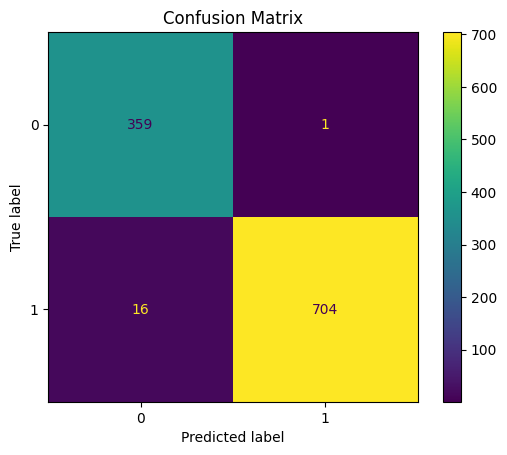

AUC-ROC: 0.999


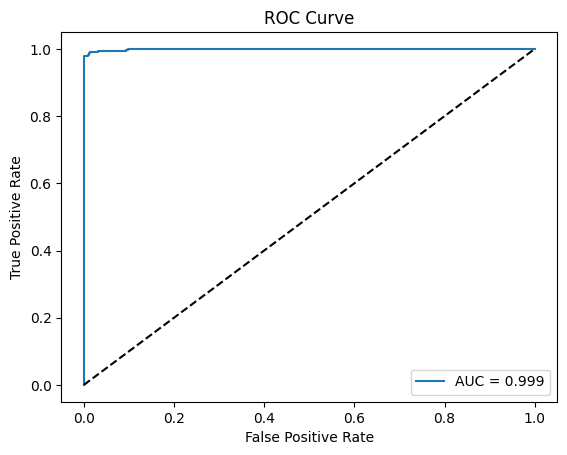

In [13]:
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(fold_final_predictions_df['ground_truth'], fold_final_predictions_df['predicted_class'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# AUC-ROC
# If you have probabilities, use them; otherwise, use predicted_class (not ideal for ROC)
if 'prob_1' in fold_final_predictions_df.columns:
    y_score = fold_final_predictions_df['prob_1']
else:
    y_score = fold_final_predictions_df['predicted_class']

auc = roc_auc_score(fold_final_predictions_df['ground_truth'], y_score)
print(f"AUC-ROC: {auc:.3f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(fold_final_predictions_df['ground_truth'], y_score)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()